## Import packages

In [245]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
import metpy as mtp
import math
from scipy import integrate
from scipy import interpolate
import pandas as pd
from random import randint

from matplotlib.pyplot import cm
from matplotlib.transforms import Bbox
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

import sys  
sys.path.insert(0, '../')
import ERA5_functions as era_fncts

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Constants

In [3]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [4]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

### Load instantaneous AHT calcs

In [5]:
aht_ds = xr.open_dataset('../aht_time_series/era5_aht_time_series.nc')

In [6]:
### Load in the necessary single lat AHT files

which_lat1 = 40
which_lat2 = 60

#ddir = 'aht_time_series/one_lat/'
#eddy_files1 = sorted(glob(ddir + 'eddy_total_' + str(which_lat1) +'*'))
#eddy_files2 = sorted(glob(ddir + 'eddy_total_' + str(which_lat2) + '*'))

#eddy_data1 = []
#for eddy in eddy_files1:
    #file_data = np.load(eddy)
    #eddy_data1.append(file_data)

#eddy_local1 = np.concatenate(eddy_data1) * geometry[era_fncts.get_lat_idx(which_lat1)]

#eddy_data2 = []
#for eddy in eddy_files2:
    #file_data = np.load(eddy)
    #eddy_data2.append(file_data)

#eddy_local2 = np.concatenate(eddy_data2) * geometry[era_fncts.get_lat_idx(which_lat2)]

eddy_local_orig1 = xr.open_dataset('../aht_time_series/era5_aht_time_series_40deg.nc')
eddy_local_orig2 = xr.open_dataset('../aht_time_series/era5_aht_time_series_60deg.nc')

eddy_local1 = era_fncts.get_djf_data(eddy_local_orig1.eddy_aht.values)
eddy_local2 = era_fncts.get_djf_data(eddy_local_orig2.eddy_aht.values)

### Choose whether or not to de-seasonalize the local AHT

In [29]:
#eddy_local1 = eddy_local1
#eddy_local2 = eddy_local2

#eddy_local_no_seas1 = np.zeros_like(eddy_local1)
#eddy_local_no_seas2 = np.zeros_like(eddy_local2)

#for i in range(len(lons)):
    #eddy_local_no_seas1[:,i] = era_fncts.remove_seasons_spline(eddy_local1[:,i], periodic=True)[0]
    #eddy_local_no_seas2[:,i] = era_fncts.remove_seasons_spline(eddy_local2[:,i], periodic=True)[0]
    
#eddy_local1 = eddy_local_no_seas1
#eddy_local2 = eddy_local_no_seas2

### Get decorrelation length scale info

In [16]:
decorr_dict = np.load('../decorr_dict.npy',allow_pickle='TRUE').item()

decorr_dict_str1 = '40_djf'
decorr_dict_str2 = '60_djf'

try:
    decorr_info1 = decorr_dict[decorr_dict_str1]
except:
    decorr_info1 = era_fncts.decorr_length_scale(eddy_local1)
    decorr_dict[decorr_dict_str1] = decorr_info1

try:
    decorr_info2 = decorr_dict[decorr_dict_str2]
except:
    decorr_info2 = era_fncts.decorr_length_scale(eddy_local2)
    decorr_dict[decorr_dict_str2] = decorr_info2
    
np.save('../decorr_dict.npy', decorr_dict) 

### Randomly sample the points

In [17]:
eddy_local1_samples = np.empty(len(eddy_local1[:,0]))
lon_samples = np.empty(720)
#For each time take a random sample at every longitude
for i in range(len(eddy_local1[:,0])):
    #for j in range(720):
        #lon_samples[j] = np.nanmean(np.random.choice(eddy_local1[:,j], 1))
    idx = np.random.randint(len(eddy_local1[:,0]), size=720)
    lon_samples = eddy_local1[idx, range(720)]
    lon_mean = np.nanmean(lon_samples)
    eddy_local1_samples[i] = lon_mean
    
eddy_local2_samples = np.empty(len(eddy_local2[:,0]))
lon_samples = np.empty(720)
#For each time take a random sample at every longitude
for i in range(len(eddy_local2[:,0])):
    #for j in range(720):
        #lon_samples[j] = np.nanmean(np.random.choice(eddy_local2[:,j], 1))
    idx = np.random.randint(len(eddy_local2[:,0]), size=720)
    lon_samples = eddy_local2[idx, range(720)]
    lon_mean = np.nanmean(lon_samples)
    eddy_local2_samples[i] = lon_mean

### Sample the points based on local correlations

In [18]:
#Decorrs are in grid points are degrees x2
decorr1 = np.mean(decorr_info1[0])
decorr2 = np.mean(decorr_info2[0])

eddy_local1_decor_samples = np.empty(len(eddy_local1[:,0]))
lon_samples = np.empty(720)

decor_adjust = 20
all_js = []
for i in range(len(eddy_local1[:,0])):
    for j in range(720):
        if j % int(decorr1 * decor_adjust) == 0: #If its the decorr length scale times 2 get a new time
            time_idx = randint(0, len(eddy_local1[:,0])-1)
        else:
            pass
        lon_samples[j] = eddy_local1[time_idx,j]
    lon_mean = np.nanmean(lon_samples)
    eddy_local1_decor_samples[i] = lon_mean
    
eddy_local2_decor_samples = np.empty(len(eddy_local2[:,0]))
lon_samples = np.empty(720)
for i in range(len(eddy_local2[:,0])):
    for j in range(720):
        if j % int(decorr2 * decor_adjust) == 0: #If its the decorr length scale times 2 get a new time
            all_js.append(j)
            time_idx = randint(0, len(eddy_local2[:,0])-1)
        else:
            pass
        lon_samples[j] = eddy_local2[time_idx,j]
    lon_mean = np.nanmean(lon_samples)
    eddy_local2_decor_samples[i] = lon_mean

### Sample points nL apart all at the same time

In [19]:
#Decorrs are in grid points are degrees x2
decorr1 = np.mean(decorr_info1[0])
decorr2 = np.mean(decorr_info2[0])

decor_adjust = 2

eddy_local1_decor_samples_t2 = np.empty(len(eddy_local1[:,0]))
lon_samples = np.empty(int(720/(decorr1* decor_adjust)))
for i in range(len(eddy_local1[:,0])):
    #start_index = i % 719
    start_index = randint(0, 719)
    current_index = start_index
    
    time_idx = randint(0, len(eddy_local1[:,0])-1)
    
    for j in range(int(720/(decorr1 * decor_adjust))):
        #time_idx = randint(0, len(eddy_local1[:,0])-1)
        lon_samples[j] = eddy_local1[time_idx, current_index]
        current_index = int(current_index + (decorr1 * decor_adjust)) % 720
        
    lon_mean = np.nanmean(lon_samples)
    eddy_local1_decor_samples_t2[i] = lon_mean
    
    
eddy_local2_decor_samples_t2 = np.empty(len(eddy_local2[:,0]))
lon_samples = np.empty(int(720/(decorr2* decor_adjust)))
for i in range(len(eddy_local2[:,0])):
    #start_index = i % 719
    start_index = randint(0, 719)
    current_index = start_index
    
    time_idx = randint(0, len(eddy_local2[:,0])-1)
    for j in range(int(720/(decorr2* decor_adjust))):
        #time_idx = randint(0, len(eddy_local2[:,0])-1)
        lon_samples[j] = eddy_local2[time_idx, current_index]
        current_index = int(current_index + (decorr2 * decor_adjust)) % 720
        
    lon_mean = np.nanmean(lon_samples)
    eddy_local2_decor_samples_t2[i] = lon_mean
    

### Gerards alternative way

In [20]:
#Decorrs are in grid points are degrees x2
decorr1 = np.mean(decorr_info1[0])
decorr2 = np.mean(decorr_info2[0])

decor_adjust = 2

eddy_local1_decor_samples_new = np.empty(len(eddy_local1[:,0]))
lon_samples = np.empty(int(720/(decorr1* decor_adjust)))
for i in range(len(eddy_local1[:,0])):
    #start_index = i % 719
    start_index = randint(0, 719)
    current_index = start_index
    
    #time_idx = randint(0, len(eddy_local1[:,0])-1)
    
    for j in range(int(720/(decorr1 * decor_adjust))):
        time_idx = randint(0, len(eddy_local1[:,0])-1)
        lon_samples[j] = eddy_local1[time_idx, current_index]
        current_index = int(current_index + (decorr1 * decor_adjust)) % 720
        
    lon_mean = np.nanmean(lon_samples)
    eddy_local1_decor_samples_new[i] = lon_mean
    
    
eddy_local2_decor_samples_new = np.empty(len(eddy_local2[:,0]))
lon_samples = np.empty(int(720/(decorr2* decor_adjust)))
for i in range(len(eddy_local2[:,0])):
    #start_index = i % 719
    start_index = randint(0, 719)
    current_index = start_index
    
    #time_idx = randint(0, len(eddy_local2[:,0])-1)
    for j in range(int(720/(decorr2* decor_adjust))):
        time_idx = randint(0, len(eddy_local2[:,0])-1)
        lon_samples[j] = eddy_local2[time_idx, current_index]
        current_index = int(current_index + (decorr2 * decor_adjust)) % 720
        
    lon_mean = np.nanmean(lon_samples)
    eddy_local2_decor_samples_new[i] = lon_mean
    

### Gerard's way with variations in decorr length scales

In [21]:
#Decorrs are in grid points are degrees x2
decorr1 = np.mean(decorr_info1[0])
decorr2 = np.mean(decorr_info2[0])

decor_adjust = 1.6

eddy_local1_decor_samples_new = np.empty(len(eddy_local1[:,0]))
#lon_samples = np.empty(int(720/(decorr1* decor_adjust)))

lon_samples_len = []
for i in range(len(eddy_local1[:,0])):
    
    lon_samples = []
    #start_index = i % 719
    start_index = randint(0, 719)
    current_index = start_index
    
    current_decorr = decorr_info1[0][current_index]
    
    #time_idx = randint(0, len(eddy_local1[:,0])-1)
    
    for j in range(int(720/(decorr1 * decor_adjust))):
        time_idx = randint(0, len(eddy_local1[:,0])-1)
        lon_samples.append(eddy_local1[time_idx, current_index])
        current_index = int(current_index + (current_decorr * decor_adjust)) % 720
        current_decorr = decorr_info1[0][current_index]
     
    lon_samples_len.append(len(lon_samples))
    lon_mean = np.nanmean(np.array(lon_samples))
    eddy_local1_decor_samples_new[i] = lon_mean
    
    
eddy_local2_decor_samples_new = np.empty(len(eddy_local2[:,0]))
#lon_samples = np.empty(int(720/(decorr2* decor_adjust)))

for i in range(len(eddy_local2[:,0])):
    lon_samples = []
    #start_index = i % 719
    start_index = randint(0, 719)
    current_index = start_index
    
    current_decorr = decorr_info2[0][current_index]
    
    #time_idx = randint(0, len(eddy_local2[:,0])-1)
    for j in range(int(720/(decorr2 * decor_adjust))):
        time_idx = randint(0, len(eddy_local2[:,0])-1)
        lon_samples.append(eddy_local2[time_idx, current_index])
        current_index = int(current_index + (current_decorr * decor_adjust)) % 720
        current_decorr = decorr_info2[0][current_index]
        
    lon_mean = np.nanmean(np.array(lon_samples))
    eddy_local2_decor_samples_new[i] = lon_mean
    

In [22]:
#lon_samples_len

### Aaron alternative way

In [23]:
#Decorrs are in grid points are degrees x2
decorr1 = np.mean(decorr_info1[0])
decorr2 = np.mean(decorr_info2[0])

decor_adjust = 1.6

eddy_local1_decor_samples_aaron = np.empty(len(eddy_local1[:,0]))
eddy_local1_flatten = eddy_local1.flatten()
lon_samples = np.empty(int(720/(decorr1*decor_adjust)))
for i in range(len(eddy_local1[:,0])):
    for j in range(int(720/(decorr1*decor_adjust))):
        random_idx = randint(0, len(eddy_local1_flatten)-1)
        lon_samples[j] = eddy_local1_flatten[random_idx]

    lon_mean = np.nanmean(lon_samples)
    eddy_local1_decor_samples_aaron[i] = lon_mean
    
    
eddy_local2_decor_samples_aaron = np.empty(len(eddy_local2[:,0]))
eddy_local2_flatten = eddy_local2.flatten()
lon_samples = np.empty(int(720/(decorr2*decor_adjust)))
for i in range(len(eddy_local2[:,0])):
    for j in range(int(720/(decorr2*decor_adjust))):
        random_idx = randint(0, len(eddy_local2_flatten)-1)
        lon_samples[j] = eddy_local2_flatten[random_idx]

    lon_mean = np.nanmean(lon_samples)
    eddy_local2_decor_samples_aaron[i] = lon_mean
    

In [24]:
print(7.2 * 111.32 * np.cos(np.deg2rad(40)))
print(11.5 * 111.32 * np.cos(np.deg2rad(60)))

613.9876853376334
640.09


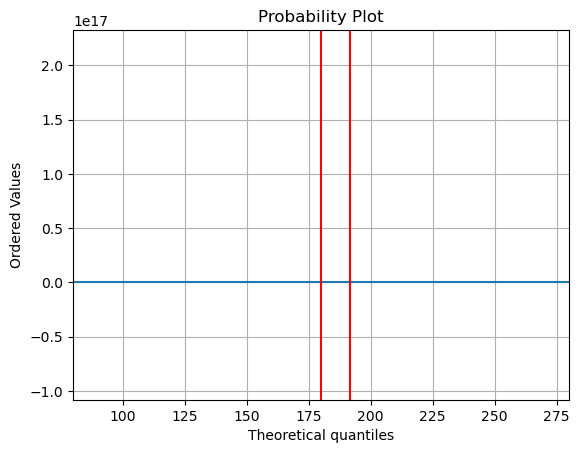

In [25]:
plt.plot(lons, decorr_info1[1])

#plt.axvline(180 + decorr1/2)
plt.xlim([80, 280])

plt.axvline(180, color='r')
plt.axvline(180 + .8 * decorr1, color='r')
plt.grid()
plt.show()

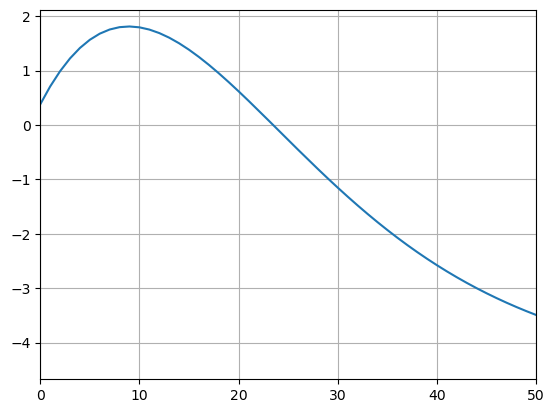

In [26]:
#plt.plot(range(360), decorr_info1[1][360:])

decorr_int = int(decorr1)
plt.plot(range(346), np.cumsum(decorr_info1[1][360 + decorr_int:]))

plt.xlim([0, 50])
plt.grid()
plt.show()

### Plot it!

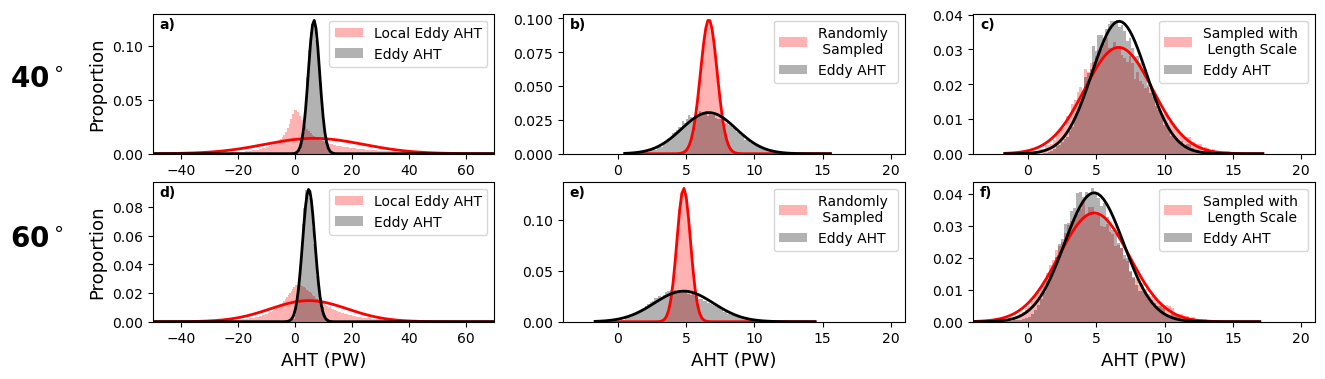

In [288]:
fig, axs = plt.subplots(2, 3, figsize=(15,4))

#eddy_zonal1 = aht_ds.eddy_aht.sel(latitude=which_lat1).values.flatten()
#eddy_zonal2 = aht_ds.eddy_aht.sel(latitude=which_lat2).values.flatten()
#eddy_zonal1 = aht_ds.eddy_aht_no_seasons.sel(latitude=which_lat1).values.flatten()
#eddy_zonal2 = aht_ds.eddy_aht_no_seasons.sel(latitude=which_lat2).values.flatten()
eddy_zonal1 = era_fncts.get_djf_data(aht_ds.eddy_aht.sel(latitude=which_lat1).values).flatten()
eddy_zonal2 = era_fncts.get_djf_data(aht_ds.eddy_aht.sel(latitude=which_lat2).values).flatten()

local_color = 'r'
zonal_color = 'k'
num_bins1 = 500
num_bins2 = 100

n_bins00, bin_edges00 = np.histogram(eddy_local1.flatten()/1e15, num_bins1)

era_fncts.plot_hist_and_gauss(axs[0,0], eddy_local1.flatten()/1e15, local_color,
                              which_bins=bin_edges00, label='Local Eddy AHT')
era_fncts.plot_hist_and_gauss(axs[0,0], eddy_zonal1/1e15, zonal_color,
                              which_bins=bin_edges00, label='Eddy AHT')
axs[0,0].legend(loc=1)


n_bins10, bin_edges10 = np.histogram(eddy_local2.flatten()/1e15, num_bins1)

era_fncts.plot_hist_and_gauss(axs[1,0], eddy_local2.flatten()/1e15, local_color,
                              which_bins=bin_edges10, label='Local Eddy AHT')
era_fncts.plot_hist_and_gauss(axs[1,0], eddy_zonal2/1e15, zonal_color,
                              which_bins=bin_edges10, label='Eddy AHT')

axs[1,0].legend(loc=1)

n_bins01, bin_edges01 = np.histogram(eddy_zonal1/1e15, num_bins2)

era_fncts.plot_hist_and_gauss(axs[0,1], eddy_local1_samples.flatten()/1e15, local_color,
                              which_bins=bin_edges01, label='Randomly \n Sampled')
era_fncts.plot_hist_and_gauss(axs[0,1], eddy_zonal1/1e15, zonal_color,
                              which_bins=bin_edges01, label='Eddy AHT')
axs[0,1].legend(loc=1)

n_bins11, bin_edges11 = np.histogram(eddy_zonal2/1e15, num_bins2)

era_fncts.plot_hist_and_gauss(axs[1,1], eddy_local2_samples.flatten()/1e15, local_color,
                              which_bins=bin_edges11, label='Randomly \n Sampled')
era_fncts.plot_hist_and_gauss(axs[1,1], eddy_zonal2/1e15, zonal_color,
                              which_bins=bin_edges11, label='Eddy AHT')

axs[1,1].legend(loc=1)

#n_bins02, bin_edges02 = np.histogram(eddy_zonal1/1e15, num_bins2)
n_bins02, bin_edges02 = np.histogram(eddy_local1_decor_samples_t2.flatten()/1e15, num_bins2)

era_fncts.plot_hist_and_gauss(axs[0,2], eddy_local1_decor_samples_t2.flatten()/1e15, local_color,
                              which_bins=bin_edges02, label='Sampled with \n Length Scale')
era_fncts.plot_hist_and_gauss(axs[0,2], eddy_zonal1/1e15, zonal_color,
                              which_bins=bin_edges02, label='Eddy AHT')
axs[0,2].legend(loc=1)

#n_bins12, bin_edges12 = np.histogram(eddy_zonal2/1e15, num_bins2)
n_bins12, bin_edges12 = np.histogram(eddy_local2_decor_samples_t2.flatten()/1e15, num_bins2)

era_fncts.plot_hist_and_gauss(axs[1,2], eddy_local2_decor_samples_t2.flatten()/1e15, local_color,
                              which_bins=bin_edges12, label='Sampled with \n Length Scale')
era_fncts.plot_hist_and_gauss(axs[1,2], eddy_zonal2/1e15, zonal_color,
                              which_bins=bin_edges12, label='Eddy AHT')

axs[1, 2].legend(loc=1)

#plt.suptitle('Comparing local and zonal AHT w/o seasons')

axs[0,0].set_ylabel('Proportion', fontsize=13)
axs[1,0].set_ylabel('Proportion', fontsize=13)

axs[1,0].set_xlabel('AHT (PW)', fontsize=13)
axs[1,1].set_xlabel('AHT (PW)', fontsize=13)
axs[1,2].set_xlabel('AHT (PW)', fontsize=13)

#axs[0,0].set_yscale('log')
#axs[0,0].set_ylim([1e-6, 1])
#axs[0,0].set_yticks([1e-6, 1e-4, 1e-2, 1e0])
#axs[1,0].set_yscale('log')
#axs[1,0].set_ylim([1e-6, 1])
#axs[1,0].set_yticks([1e-6, 1e-4, 1e-2, 1e0])

axs[0,0].set_xlim([-50, 70])
axs[1,0].set_xlim([-50, 70])
#axs[0,1].set_xlim([-1, 13])
#axs[1,1].set_xlim([-1, 13])
axs[0,1].set_xlim([-4, 21])
axs[1,1].set_xlim([-4, 21])
axs[0,2].set_xlim([-4, 21])
axs[1,2].set_xlim([-4, 21])

subplot_labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

for idx, ax in enumerate(axs.flatten()):
    ax.text(x=0.02, y=0.9, s=subplot_labels[idx], transform=ax.transAxes, fontweight='bold')
    
fig.text(x=.03, y=0.7, s='40$^\circ$', fontsize=20, fontweight='bold')
fig.text(x=.03, y=0.3, s='60$^\circ$', fontsize=20, fontweight='bold')

#plt.savefig('../figures/4_12_22_meeting/local_zonal_aht_comparisons_djf_norm_scale_new', dpi=1000)
#plt.savefig('../figures/4_12_22_meeting/local_zonal_aht_comparisons_djf_norm_scale_new.eps', format='eps')

plt.show()

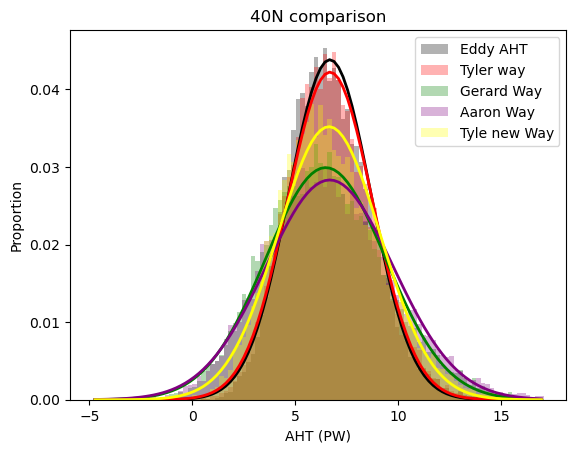

In [28]:
era_fncts.plot_hist_and_gauss(plt, eddy_zonal1/1e15, zonal_color,
                              which_bins=bin_edges12, label='Eddy AHT')

era_fncts.plot_hist_and_gauss(plt, eddy_local1_decor_samples.flatten()/1e15, local_color,
                              which_bins=bin_edges12, label='Tyler way')

era_fncts.plot_hist_and_gauss(plt, eddy_local1_decor_samples_new.flatten()/1e15, 'green',
                              which_bins=bin_edges12, label='Gerard Way')

era_fncts.plot_hist_and_gauss(plt, eddy_local1_decor_samples_aaron.flatten()/1e15, 'purple',
                              which_bins=bin_edges12, label='Aaron Way')

era_fncts.plot_hist_and_gauss(plt, eddy_local1_decor_samples_t2.flatten()/1e15, 'yellow',
                              which_bins=bin_edges12, label='Tyle new Way')

plt.legend(loc=0)
plt.xlabel('AHT (PW)')
plt.ylabel('Proportion')

plt.title('40N comparison')

plt.show()

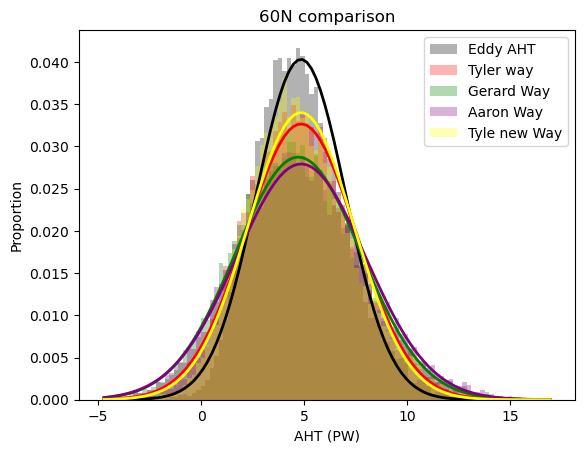

In [29]:
era_fncts.plot_hist_and_gauss(plt, eddy_zonal2/1e15, zonal_color,
                              which_bins=bin_edges12, label='Eddy AHT')

era_fncts.plot_hist_and_gauss(plt, eddy_local2_decor_samples.flatten()/1e15, local_color,
                              which_bins=bin_edges12, label='Tyler way')

era_fncts.plot_hist_and_gauss(plt, eddy_local2_decor_samples_new.flatten()/1e15, 'green',
                              which_bins=bin_edges12, label='Gerard Way')

era_fncts.plot_hist_and_gauss(plt, eddy_local2_decor_samples_aaron.flatten()/1e15, 'purple',
                              which_bins=bin_edges12, label='Aaron Way')

era_fncts.plot_hist_and_gauss(plt, eddy_local2_decor_samples_t2.flatten()/1e15, 'yellow',
                              which_bins=bin_edges12, label='Tyle new Way')

plt.legend(loc=0)
plt.xlabel('AHT (PW)')
plt.ylabel('Proportion')

plt.title('60N comparison')

plt.show()

In [30]:
eddy_local1_no_means = eddy_local1 - np.mean(eddy_local1, axis=1)[:,None]
eddy_local2_no_means = eddy_local2 - np.mean(eddy_local2, axis=1)[:,None]

print('Eddy local1 std is: ' + str(round(np.std(eddy_local1.flatten()/1e15), 3)))
print('Eddy local1 no mean std is: ' + str(round(np.std(eddy_local1_no_means.flatten()/1e15), 3)))

print('Eddy local2 std is: ' + str(round(np.std(eddy_local2.flatten()/1e15), 3)))
print('Eddy local2 no mean std is: ' + str(round(np.std(eddy_local2_no_means.flatten()/1e15), 3)))

Eddy local1 std is: 17.295
Eddy local1 no mean std is: 17.18
Eddy local2 std is: 13.604
Eddy local2 no mean std is: 13.431


### Quantitatively compare distribution quantiles

In [232]:
### Testing out some error quantification things
def standardize(array):
    array = array.flatten()
    return (array - np.mean(array)) / np.std(array)

eddy_local1_std = standardize(eddy_local1)
eddy_zonal1_std = standardize(eddy_zonal1)

eddy_local1_creation_std = standardize(eddy_local1_decor_samples_t2)
eddy_local1_bad_creation_std = standardize(eddy_local1_samples.flatten())

eddy_local2_std = standardize(eddy_local2)
eddy_zonal2_std = standardize(eddy_zonal2)

eddy_local2_creation_std = standardize(eddy_local2_decor_samples_t2)
eddy_local2_bad_creation_std = standardize(eddy_local2_samples.flatten())

### Compare local values against Gaussians

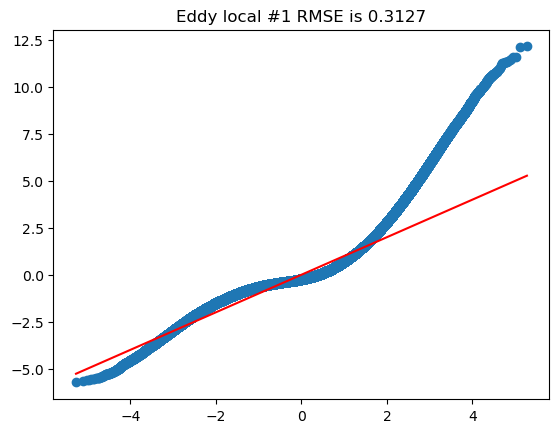

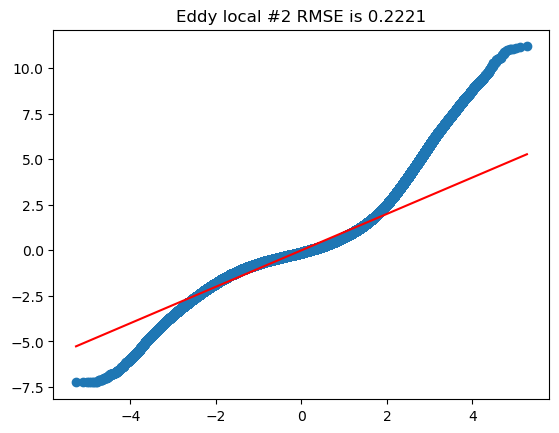

In [258]:
 
local1_quantiles = era_fncts.get_quantiles(eddy_local1_std)
    
plt.scatter(local1_quantiles[0], local1_quantiles[1])
plt.plot(local1_quantiles[0], local1_quantiles[0], color='r')
plt.title(f'Eddy local #1 RMSE is {round(local1_quantiles[2], 4)}')
plt.show()

local2_quantiles = era_fncts.get_quantiles(eddy_local2_std)
    
plt.scatter(local2_quantiles[0], local2_quantiles[1])
plt.plot(local2_quantiles[0], local2_quantiles[0], color='r')
plt.title(f'Eddy local #2 RMSE is {round(local2_quantiles[2], 4)}')
plt.show()

In [246]:
zonal_local1 = era_fncts.compare_quantiles(eddy_zonal1_std, eddy_local1_std)
zonal_local_creation1 = era_fncts.compare_quantiles(eddy_zonal1_std, eddy_local1_creation_std)
zonal_local_bad_creation1 = era_fncts.compare_quantiles(eddy_zonal1_std, eddy_local1_bad_creation_std)

zonal_local2 = era_fncts.compare_quantiles(eddy_zonal2_std, eddy_local2_std)
zonal_local_creation2 = era_fncts.compare_quantiles(eddy_zonal2_std, eddy_local2_creation_std)
zonal_local_bad_creation2 = era_fncts.compare_quantiles(eddy_zonal2_std, eddy_local2_bad_creation_std)

In [247]:
print(f'Zonal local #1 RMSE is {round(zonal_local1[2], 4)}')
print(f'Zonal local bad creation #1 RMSE is {round(zonal_local_bad_creation1[2], 4)}')
print(f'Zonal local creation #1 RMSE is {round(zonal_local_creation1[2], 4)}')
print('--------------')
print(f'Zonal local #2 RMSE is {round(zonal_local2[2], 4)}')
print(f'Zonal local bad creation #2 RMSE is {round(zonal_local_bad_creation2[2], 4)}')
print(f'Zonal local creation #2 RMSE is {round(zonal_local_creation2[2], 4)}')

Zonal local #1 RMSE is 0.2795
Zonal local bad creation #1 RMSE is 0.0526
Zonal local creation #1 RMSE is 0.0166
--------------
Zonal local #2 RMSE is 0.1948
Zonal local bad creation #2 RMSE is 0.0662
Zonal local creation #2 RMSE is 0.01


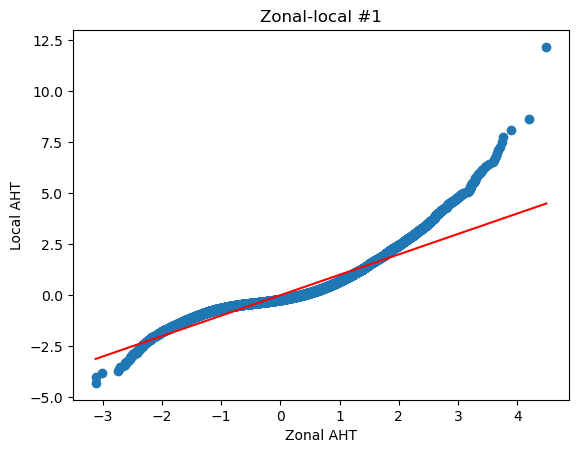

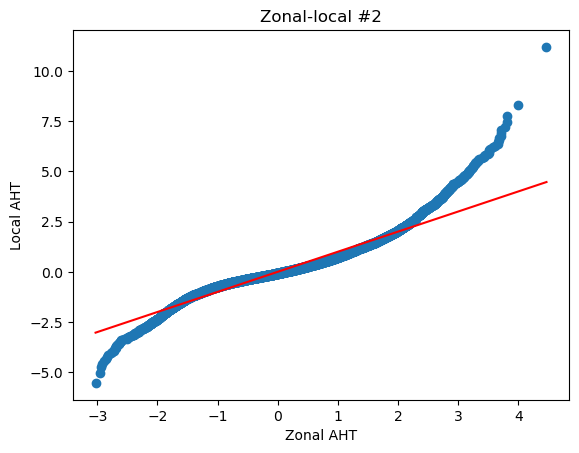

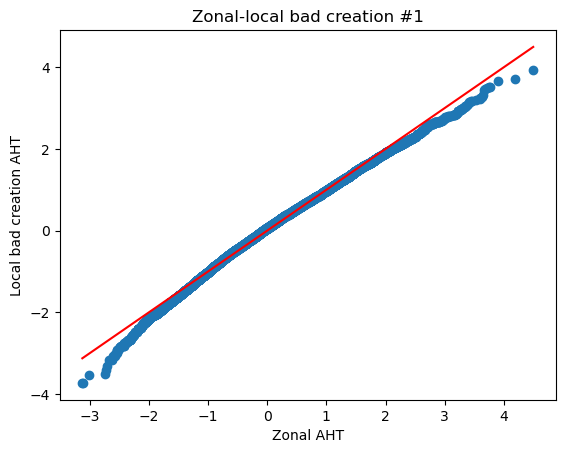

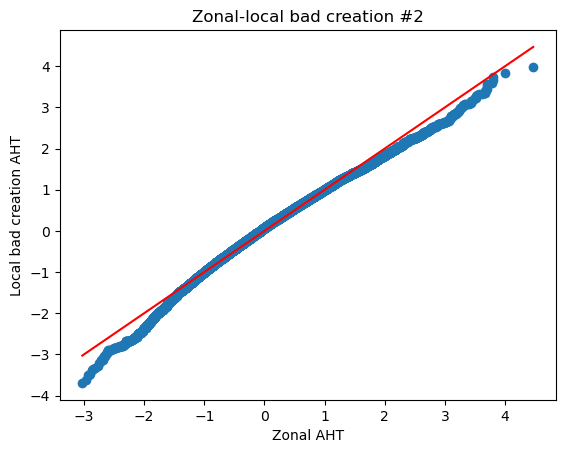

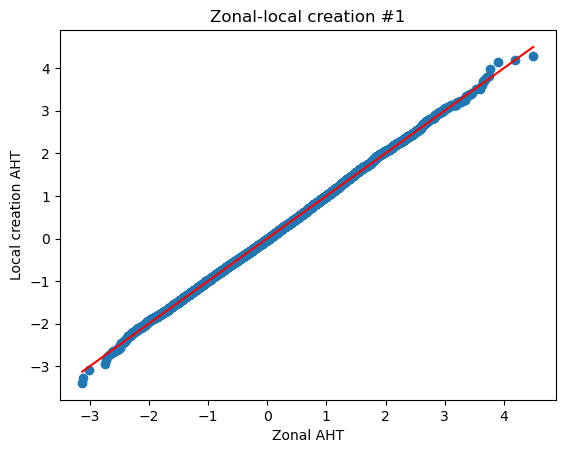

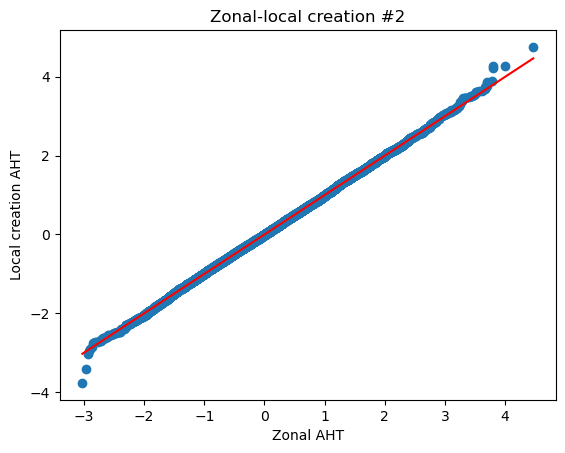

In [256]:
plt.scatter(zonal_local1[0], zonal_local1[1])
plt.plot(zonal_local1[0], zonal_local1[0], color='r')
plt.xlabel('Zonal AHT')
plt.ylabel('Local AHT')
plt.title('Zonal-local #1')
plt.show()

plt.scatter(zonal_local2[0], zonal_local2[1])
plt.plot(zonal_local2[0], zonal_local2[0], color='r')
plt.xlabel('Zonal AHT')
plt.ylabel('Local AHT')
plt.title('Zonal-local #2')
plt.show()

plt.scatter(zonal_local_bad_creation1[0], zonal_local_bad_creation1[1])
plt.plot(zonal_local_bad_creation1[0], zonal_local_bad_creation1[0], color='r')
plt.xlabel('Zonal AHT')
plt.ylabel('Local bad creation AHT')
plt.title('Zonal-local bad creation #1')
plt.show()

plt.scatter(zonal_local_bad_creation2[0], zonal_local_bad_creation2[1])
plt.plot(zonal_local_bad_creation2[0], zonal_local_bad_creation2[0], color='r')
plt.xlabel('Zonal AHT')
plt.ylabel('Local bad creation AHT')
plt.title('Zonal-local bad creation #2')
plt.show()

plt.scatter(zonal_local_creation1[0], zonal_local_creation1[1])
plt.plot(zonal_local_creation1[0], zonal_local_creation1[0], color='r')
plt.xlabel('Zonal AHT')
plt.ylabel('Local creation AHT')
plt.title('Zonal-local creation #1')
plt.show()

plt.scatter(zonal_local_creation2[0], zonal_local_creation2[1])
plt.plot(zonal_local_creation2[0], zonal_local_creation2[0], color='r')
plt.xlabel('Zonal AHT')
plt.ylabel('Local creation AHT')
plt.title('Zonal-local creation #2')
plt.show()

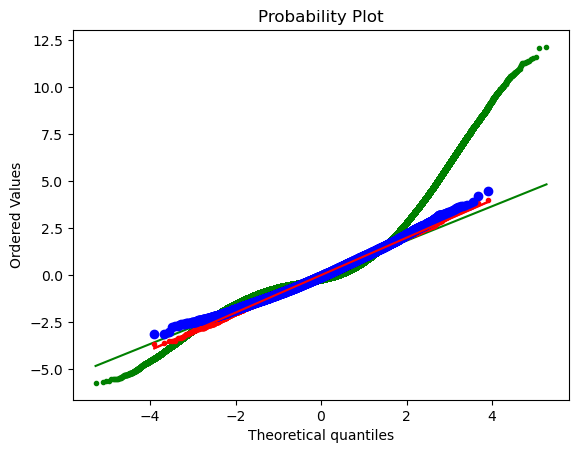

In [96]:
fig = plt.figure()
ax = fig.add_subplot(111)

res_local = sc.probplot(eddy_local1_std, fit=True, plot=ax)
#res_local_creation = sc.probplot(eddy_local1_creation_std, fit=True, plot=ax)
res_local_creation = sc.probplot(eddy_local1_bad_creation_std, fit=True, plot=ax)
res_zonal = sc.probplot(eddy_zonal1_std, fit=True, plot=ax)
#sc.probplot(eddy_local1.flatten(), plot=plt)

ax.get_lines()[0].set_markerfacecolor('g')
ax.get_lines()[0].set_markeredgecolor('g')
ax.get_lines()[0].set_markersize(3)
ax.get_lines()[1].set_color('g')

ax.get_lines()[1].set_markerfacecolor('b')
ax.get_lines()[1].set_markeredgecolor('b')
ax.get_lines()[1].set_markersize(3)
ax.get_lines()[2].set_color('b')


ax.get_lines()[2].set_markerfacecolor('r')
ax.get_lines()[2].set_markeredgecolor('r')
ax.get_lines()[2].set_markersize(3)
ax.get_lines()[3].set_color('r')

plt.show()

In [91]:
from statistics import NormalDist
which_field = np.sort(eddy_zonal1_std)

test = NormalDist(mu=np.mean(which_field), sigma=np.std(which_field)).inv_cdf(0.95)

In [154]:
def get_quantiles(field):
    
    field = np.sort(field)
    
    vals = np.zeros(len(field))
    n = len(field)

    for i in range(n):
        if i == 0:
            vals[i] = 1 - 0.5**(1/n)
        elif i == (n-1):
            vals[i] = 0.5**(1/n)
        else:
            vals[i] = ((i + 1) - 0.3175) / (n + 0.365)

    quantiles = sc.norm.ppf(vals)
    
    rmse = np.mean(np.sqrt((field - quantiles)**2))
    
    return quantiles, field, rmse

    

In [214]:
def compare_quantiles(field1, field2):
    
    field1 = np.sort(field1)
    field2 = np.sort(field2)
    
    quants_to_interp = sc.mstats.rankdata(field1.flatten()) / len(field1.flatten())
    
    field2_interped = np.quantile(field2.flatten(), quants_to_interp)
    
    rmse = np.mean(np.sqrt((field1 - field2_interped)**2))
    
    return field1, field2_interped, rmse
    

In [215]:
zonal_local = compare_quantiles(eddy_zonal1_std, eddy_local1_std)
zonal_local_creation = compare_quantiles(eddy_zonal1_std, eddy_local1_creation_std)
zonal_local_bad_creation = compare_quantiles(eddy_zonal1_std, eddy_local1_bad_creation_std)

In [216]:
print(f'Zonal local RMSE is {zonal_local[2]}')
print(f'Zonal local creation RMSE is {zonal_local_creation[2]}')
print(f'Zonal local bad creation RMSE is {zonal_local_bad_creation[2]}')

Zonal local RMSE is 0.27945465710080175
Zonal local creation RMSE is 0.01662846238285754
Zonal local bad creation RMSE is 0.05255479300656769


In [155]:
local_quants = get_quantiles(eddy_local1_std)
zonal_quants = get_quantiles(eddy_zonal1_std)

local_creation_quants = get_quantiles(eddy_local1_creation_std)
local_bad_creation_quants = get_quantiles(eddy_local1_bad_creation_std)

In [157]:
print(f'Local RMSE is {local_quants[2]}')
print(f'Zonal RMSE is {zonal_quants[2]}')
print(f'Local creation RMSE is {local_creation_quants[2]}')
print(f'Local bad creation RMSE is {local_bad_creation_quants[2]}')

Local RMSE is 0.31267085355724683
Zonal RMSE is 0.05649916743651518
Local creation RMSE is 0.0698159301882495
Local bad creation RMSE is 0.008974743548048378


In [144]:
which_field = np.sort(eddy_local1_std)

vals = np.zeros(len(which_field))
n = len(which_field)

for i in range(n):
    if i == 0:
        vals[i] = 1 - 0.5**(1/n)
    elif i == (n-1):
        vals[i] = 0.5**(1/n)
    else:
        vals[i] = ((i + 1) - 0.3175) / (n + 0.365)

quantiles = sc.norm.ppf(vals)


#quantiles = dist.ppf(val), for

       # 0.5**(1/n),                  for i = n
  #val = (i - 0.3175) / (n + 0.365),  for i = 2, ..., n-1
       # 1 - 0.5**(1/n),              for i = 1

In [166]:
which_field = np.sort(eddy_zonal1_std)
real_data = sc.norm.ppf(which_field, loc=np.mean(which_field), scale=np.std(which_field))

In [167]:
real_data

array([nan, nan, nan, ..., nan, nan, nan])

0.31267085355724683


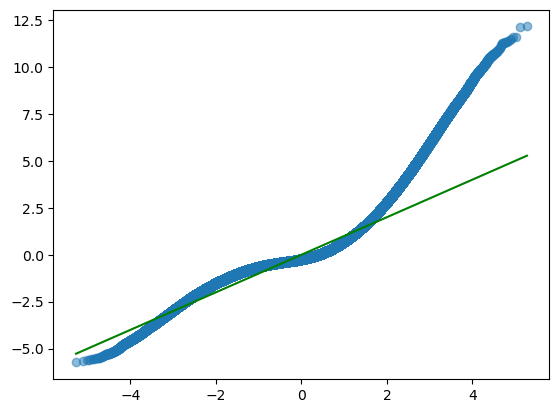

In [153]:
plt.scatter(quantiles, which_field, alpha=0.5)

plt.plot(quantiles, quantiles, color='g')
#res_local = sc.probplot(eddy_local1_std, fit=True, plot=plt)

print(np.mean(np.sqrt((which_field - quantiles)**2)))
plt.show()

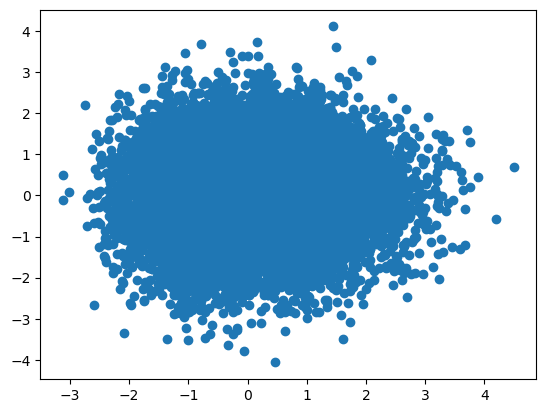

In [89]:
which_field = np.sort(eddy_zonal1_std)
gaus_test = np.random.normal(loc=np.mean(which_field), scale=np.std(which_field), size=len(which_field))

plt.scatter(which_field, gaus_test)

plt.show()

In [90]:
gaus_test

array([-0.10266957,  0.48532455,  0.09383709, ...,  0.4575865 ,
       -0.57683892,  0.67901015])

In [54]:
print(res_local[1][2])
print(res_local_creation[1][2])
print(res_zonal[1][2])

0.9171611727982273
0.9998916167996587
0.9966733058665862


In [227]:
from statsmodels.graphics.gofplots import qqplot_2samples
test = qqplot_2samples(eddy_local1_std, eddy_zonal1_std, line='45')

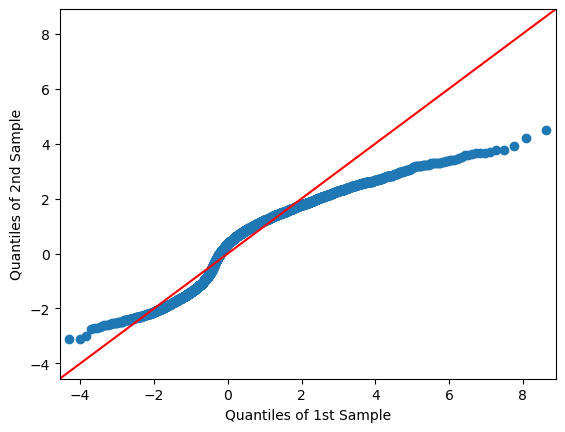

In [228]:
test



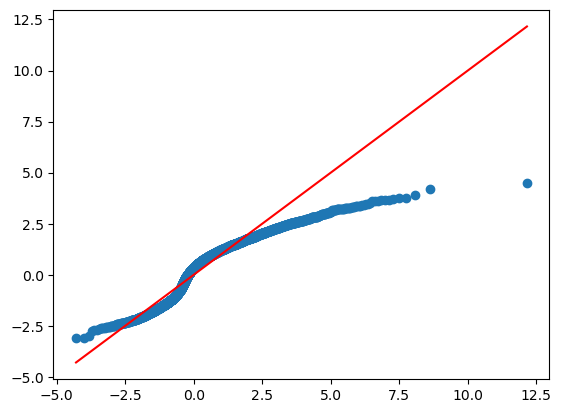

In [230]:
plt.scatter(zonal_local[1], zonal_local[0])
plt.plot(zonal_local[1], zonal_local[1], color='r')
plt.show()

In [208]:
zonal_quants = sc.mstats.rankdata(eddy_zonal1_std.flatten()) / len(eddy_zonal1_std.flatten())

In [209]:
zonal_quants

array([0.59799169, 0.58566482, 0.73614958, ..., 0.74300554, 0.85484765,
       0.91682825])

In [210]:
local_interped = np.quantile(eddy_local1_std.flatten(), zonal_quants)

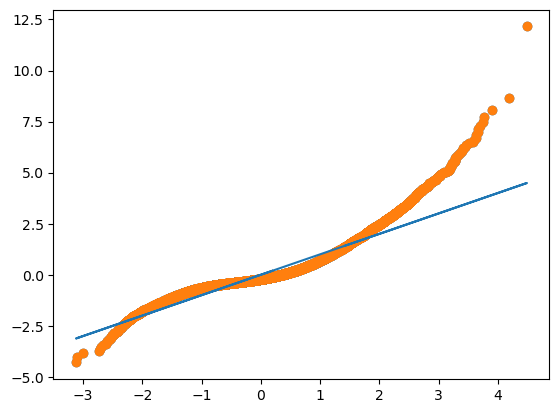

In [213]:
plt.scatter(eddy_zonal1_std, local_interped)

plt.plot(eddy_zonal1_std, eddy_zonal1_std)
plt.show()

In [196]:
pprint(np.shape(sc.norm.ppf(np.sort(test_rank)[:-1])))
print(np.sort(sc.norm.ppf(np.sort(test_rank)[:-1])))

(14439,)
[-3.81082435 -3.63590323 -3.53003005 ...  3.53003005  3.63590323
  3.81082435]


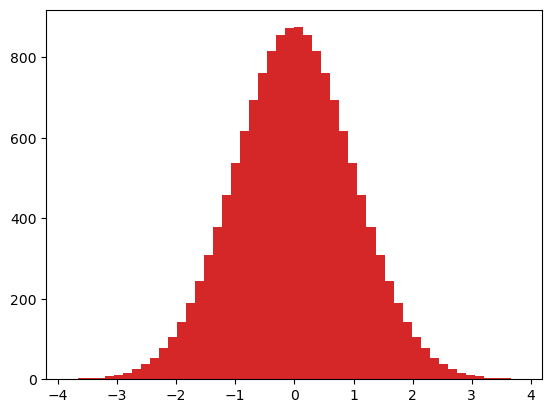

In [198]:
plt.hist(sc.norm.ppf(np.sort(test_rank)[:-1]), bins=50)

plt.show()

In [56]:
!pip install statsmodels
import statsmodels

     |████████████████████████████████| 9.9 MB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 45.9 MB/s eta 0:00:01
     |████████████████████████████████| 40 kB 12.3 MB/s eta 0:00:01
  Attempting uninstall: packaging
    Found existing installation: packaging 21.0
    Uninstalling packaging-21.0:
      Successfully uninstalled packaging-21.0


14440

In [285]:
savings = 2000000
annual_usage = 160000
interest_rate = 0.03

earnings = 100000

time_series = []
while savings > 0:
    time_series.append(savings)
    
    interest_earned = savings * (interest_rate)
    savings = savings - (annual_usage - interest_earned) + earnings
    
    

KeyboardInterrupt: 

In [ ]:
plt.plot(range(len(time_series)), time_series)

plt.show()